In [242]:
import graphviz



T = []
COVER = []
COLOR = {}
U = {}
M = {}
DEMAND = {}
PATH_FLOW = {}
PATH_COVER_COLOR = ["red", "green", "blue", "orange"]



#Procedura che permette di leggere un grafo in formato Graphviz e lo elabora
#in un dizionario gestibile dal seguente codice:

def graphviz_reader(nome_file : str) -> dict:

    grafo = {}
    file = open(f"Grafi/{nome_file}.dot", mode="r")
    lines = file.readlines()
    lines.pop(0)
    lines.pop(0)
    lines.pop(lines.__len__()-1)

    for line in lines:

        values = line.strip()
        edge = values.split(" -> ")

        if edge[0] not in grafo:

            grafo[edge[0]] = []

        if edge[1] not in grafo:

            grafo[edge[1]] = []

        grafo[edge[0]].append(edge[1])
        

    file.close()

    return grafo



#Procedura per salvare un grafo da dizionario a formato .dot leggibile da
#graphviz

def save_to_graphviz(grafo : dict, nomeFile : str, edge_values : dict | None, cover : list | None, values : bool) -> None:

    file = open(f"Grafi/{nomeFile}.dot", mode="w+")
    graph = "digraph{\n\trankdir=LR\n"
    nodes = ""
    edges = ""

    for node in grafo.keys():

        for neighbours in grafo[node]:

            if values:

                colors = ""
                key = node+"|"+neighbours

                if (key) in edge_values and edge_values[key] != 0:

                    colors = ' color="'
                    node_index = 0 #Serve a scorrere gli elementi nella lista
                    path_index = 0 #Serve a tenere traccia del numero del percorso
                    count_path = 0 #Serve a tenere traccia del flusso su un arco

                    for path in cover:

                        while node_index < path.__len__() - 1 and (count_path < edge_values[key]):

                            #Controllo nel singolo percorso se un arco è presente come nodo + successore

                            if (node == path[node_index]) and (neighbours == path[node_index + 1]):

                                colors += f'{PATH_COVER_COLOR[path_index]}:'
                                count_path += 1

                                #Termino appena trovo una corrispondenza

                                break 
                        
                            node_index += 1
                        
                        #Cambio percorso e reimposto l'indice

                        node_index = 0

                        #Passo al percorso successivo aggiornando l'indice
                
                        path_index += 1 #

                    #Rimuove gli ultimi : in eccesso e aggiunge il terminatore finale
                    colors = colors[:-1]
                    colors += '"'
                    edges += f"\t{node} -> {neighbours} [label={edge_values[key]} {colors}]\n"
                
                else:

                    edges += f"\t{node} -> {neighbours} [label=0]\n"

            else:

                edges += f"\t{node} -> {neighbours} [label=0]\n"

    graph += nodes + edges + "}"
    file.write(graph)
    file.close()

Il grafo utilizzato è il seguente:

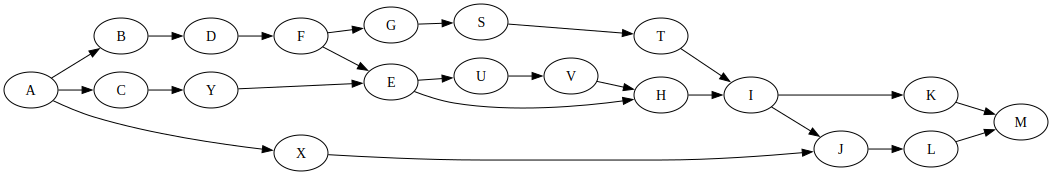

In [243]:
nomeGrafo = "Grafo 4"
grafo = graphviz.Source.from_file(directory="Grafi", filename=f"{nomeGrafo}.dot", format="svg", engine="dot")

grafo

Procedo quindi ad importare il file e trasformarlo in dizionario. Successivamente sdoppio tutti i nodi come da paper in (u-, u+):

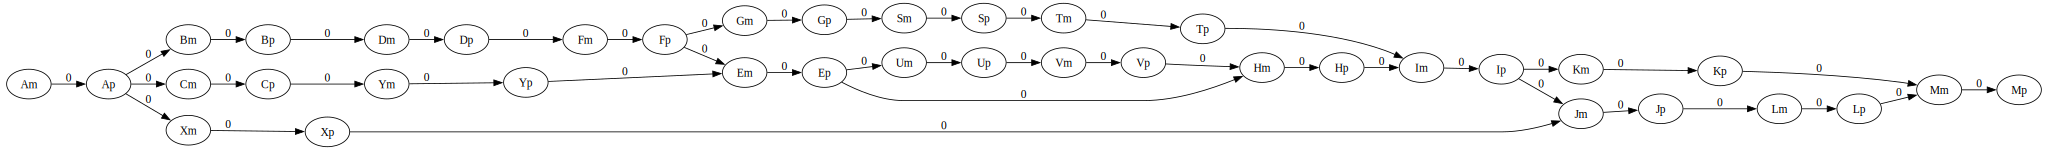

In [244]:
G = graphviz_reader(f"{nomeGrafo}")



#Procedura che converte un grafo G in G* come da paper. Ogni nodo viene 
#convertito in una coppia (u-, u+) collegati da un arco. Tutti gli archi
#uscenti partono da u+ e si collegano agli u- dei successori.

def CONVERT_GRAPH(graph: dict) -> dict:

    G_STAR = {}

    for v in graph.keys():

       u1 = v + "m"
       u2 = v + "p"
       G_STAR[u1] = [u2]
       G_STAR[u2] = list()
       
       for neighbours in G[v]:
        
        next = neighbours + "m"
        G_STAR[u2].append(next)

    return G_STAR



G = CONVERT_GRAPH(G)
save_to_graphviz(G, f"{nomeGrafo} convertito", None, None, False)
grafo_convertito = graphviz.Source.from_file(directory="Grafi", filename=f"{nomeGrafo} convertito.dot", format="svg", engine="dot")

grafo_convertito


Procedo quindi ad iniziarlizzare tutti i valori necessari per il calcolo della path cover:

In [245]:
#Inizializza i valori di COLOR, PATH FLOW etc..

def init_values(graph : dict, converted : bool) -> None:

    index = 0

    for node in graph.keys():

        COLOR[node] = 1
        U[node] = 0
        M[node] = 1

        for neighbours in graph[node]:

            edge = node + "|" + neighbours

            if converted and ("m" in node):

                DEMAND[edge] = 1

            else:

                DEMAND[edge] = 0
            
            PATH_FLOW[edge] = 0


init_values(G, True)


E proseguo successivamente all'implementazione di tutti i metodi necessari alla corretta esecuzione della path cover:

In [246]:
#Aggiorna il numero di vertici scoperti solamente se non erano stati ancora
#effettivamente scoperti. Sottrae quindi uno al valore totale e restituisce
#il valore.

def update_covered_node(node :str, to_be_covered: int) -> int:

    if M[node] == 1:

        M[node] = 0
        to_be_covered -= 1
        
        return to_be_covered

    else:

        return to_be_covered



#Dato che devo riutilizzare questo algoritmo per Ford_Fulkerson, devo poter
#escludere il calcolo di m[v] e u[v] quando necessario tramite il valore 
#booleano path_cover che mi permette di dire di calcolarla (True) o non
#calcolarla (False).

def DFS(path_cover : bool, graph : dict) -> None:

    #Imposto bianchi tutti i vertici.
    if path_cover:

        for v in COLOR.keys():

            COLOR[v] = 1

    for v in graph.keys():

        if COLOR[v] == 1:

            DFS_VISIT(v, path_cover, graph, None)



def DFS_VISIT(node: str, path_cover : bool, graph : dict, sink : str | None) -> None:

    #Se una lista di adiancenza è vuota (non ha successori)

    if not T.__contains__(sink):

        T.append(node)

        if not graph[node] and path_cover:

            U[node] = M[node]

        else:

            max = -1
            max_node = ""

            for v in graph[node]:

                if COLOR[v] == 1:

                    DFS_VISIT(v, path_cover, graph, sink)

                if U[v] > max and path_cover:

                    max = U[v]
                    max_node = v

            if path_cover:

                U[node] = M[node] + U[max_node]
        
        COLOR[node] = 0

    #COLOR[node] = 0
    #T.insert(0, node)



def PATH_COVER() -> None:

    #Variabile che serve per contare i vertici ancora da scoprire, termino 
    #quando gli ho scoperti tutti

    to_be_covered = G.keys().__len__()

    while to_be_covered > 0:

        #Calcolo l'ordinamento topologico per iniziare ad inserire
        #nella cover la sorgente segnangola successivamente come coperta.
        
        #Definisco inoltre un indice per spostarmi direttamente al nodo 
        #massimo tra ogni predecessore.

        DFS(True, G)
        temp_cover = []
        topological_index = 0
        temp_cover.append(T[0])
        to_be_covered = update_covered_node(T[0], to_be_covered)
        inspected_node = T[topological_index]

        #Attraverso l'ordinamento topologico selezionando il massimo tra
        #ogni predecessore (guardando la lista di adiacenza). Posso eseguire 
        #questa operazione solamente se il nodo ispezionato ha una lista di 
        #adiacenza.

        while not (not G[inspected_node]):

            max = -1
            max_node = ""

            for w in G[inspected_node]:

                if U[w] > max:

                    max = U[w]
                    max_node = w


            #Una volta trovato il massimo lo segno come preso m[x] = 0 e lo
            #aggiungo alla copertura, spostandomi successivamente 
            #sull'elemento massimo appena trovato.

            to_be_covered = update_covered_node(max_node, to_be_covered)
            temp_cover.append(max_node)
            #DEMAND[f"{inspected_node}|{max_node}"] += 1
            PATH_FLOW[f"{inspected_node}|{max_node}"] += 1
            topological_index = T.index(max_node)
            inspected_node = T[topological_index]
            

        COVER.append(temp_cover.copy())
        temp_cover.clear()
        T.clear()



Il flusso totale attuale nel grafo è dato dal PATH FLOW, calcolato in PATH_COVER ed è il seguente:

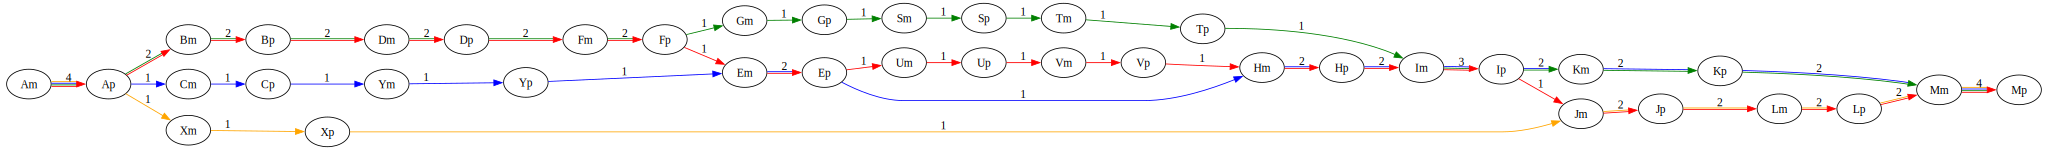

In [247]:
PATH_COVER()

save_to_graphviz(G, f"{nomeGrafo} flow", PATH_FLOW, COVER, True)
grafo_convertito = graphviz.Source.from_file(directory="Grafi", filename=f"{nomeGrafo} flow.dot", format="svg", engine="dot")
grafo_convertito

In [248]:
#Mi permette di convertire il grafo residuo (composto da <edge : valore>) in 
#un dizionario composto solo dai nodi e dagli archi presenti nel grafo
#residuo, ovvero nel formato <nodo : [successori]>

def dict_to_graph(d : dict) -> dict:

    graph = {}

    for key in d.keys():

        values = key.split("|")

        if values[0] not in graph:

            graph[values[0]] = []

        if values[1] not in graph:

            graph[values[1]] = []
        
        graph[values[0]].append(values[1])

    return graph



def FORD_FULKERSON() -> None:

    RESIDUAL_GRAPH = PATH_FLOW.copy()
    MAX_FLOW = PATH_FLOW.copy()

    #Per prima cosa inizializzo i colori per la DFS, non utilizzo la procedura
    #già presente nella DFS perchè quella serve per la path cover. In questo
    #caso i colori vengono modificati man mano dal calcolo del grafo residuo
    #e devono rimanere modificati così per il corretto calcolo di un cammino
    #aumentante e non inizializzati ogni volta a 1.
    
    for v in COLOR.keys():

        COLOR[v] = 1

    for edge in MAX_FLOW.keys():

        MAX_FLOW[edge] = 0

    for edge in PATH_FLOW.keys():

        #c = f(e) - d(e) (per ciascun arco) flusso - domanda

        RESIDUAL_GRAPH[edge] -= DEMAND[edge] 

        #Come detto in precedenza, scarto tutti i valori <= 0 e provvedo già 
        #ad inizializzare i valori per la DFS "scartando" i nodi che non 
        #possono più essere attraversati. Dato che un nodo con valore 0
        #non può più essere attraversato, significa anche che non può
        #ne più essere raggiunto ne collegarsi ad altri nodi in quanto
        #privo di capacità residua. Provvedo quindi ad impostare a 0 il 
        #colore di questo nodo (-, +) per escluderlo dalla DFS.

        if RESIDUAL_GRAPH[edge] <= 0:

            del RESIDUAL_GRAPH[edge]
            nodes = edge.split("|")
            COLOR[nodes[0]] = 0
            COLOR[nodes[1]] = 0

    #Il dizionario del grafo residuo mantiene come valore la capacità residua
    #e non una lista di adiacenza, che è quello che servirebbe per la visita
    #in profondità. Procedo quindi a convertire questo dizionario in un grafo
    #visitabile. Inizializzo anche due variabili per tenere traccia della
    #sorgente e della destinazione di tutti i cammini. Se un cammino
    #aumentante non è dalla sorgente alla destinazione allora il ciclo termina. 

    res_dfs = dict_to_graph(RESIDUAL_GRAPH)
    source = list(res_dfs.keys())[0]
    sink = list(res_dfs.keys())[list(res_dfs.keys()).__len__() - 1]


    #Una volta trovata la rete residua, procedo a trovare un cammino aumentante
    #dalla sorgente alla destinazione tramite una visita in profondità. Il
    #cammino aumentante sarà dato proprio dall'ordinamento topologico T come
    #nella path cover.   

    DFS_VISIT(source, False, res_dfs, sink)
    
    #Una volta che ho trovato il cammino aumentante procedo a trovare il valore
    #minimo (bottleneck) e sottrarlo al dal flusso. Il cammino aumentante
    #ci permette di migliorare l'approssimazione della path cover. Proseguo
    #finché non trovo più cammini aumentanti.

    while T:

        print("Cammino aumentante:")
        print(T)

        if not(T[0] == source and T[T.__len__() - 1] == sink):

            break

        print("Il cammino aumentante è nella cover?")
        print(T in COVER)

        index = 0
        bottleneck = 10000

        #Calcolo il bottleneck (minimo del cammino aumentante)

        while index < T.__len__() - 1:

            edge = T[index] + "|" + T[index+1]

            if RESIDUAL_GRAPH[edge] < bottleneck:

                bottleneck = RESIDUAL_GRAPH[edge]

            index += 1

        index = 0

        while index < T.__len__() - 1:

            edge = T[index] + "|" + T[index+1]
            
            if edge in RESIDUAL_GRAPH:

                reversed_edge = T[index+1] + "|" + T[index]
                RESIDUAL_GRAPH[edge] -= bottleneck

                if reversed_edge in RESIDUAL_GRAPH:
                    
                    RESIDUAL_GRAPH[reversed_edge] += bottleneck

                else:

                    RESIDUAL_GRAPH[reversed_edge] = (RESIDUAL_GRAPH[edge])

                #Rimuovo gli archi nulli dalla rete residua.
                
                if RESIDUAL_GRAPH[edge] <= 0:

                    del RESIDUAL_GRAPH[edge]
                    nodes = edge.split("|")
                    COLOR[nodes[0]] = 0
                    COLOR[nodes[1]] = 0 

                if RESIDUAL_GRAPH[reversed_edge] == 0:
            
                    del RESIDUAL_GRAPH[reversed_edge]

                #Sommo il bottleneck al MAX_FLOW
                MAX_FLOW[edge] += bottleneck

            index += 1

        res_dfs = dict_to_graph(RESIDUAL_GRAPH)
        T.clear()
        DFS_VISIT(source, False, res_dfs, sink)

    print("Nessun percorso disponibile")
   
    #Una volta che non trovo più cammini aumentanti posso procedere a calcolare
    #la path cover finale, ovvero il path_flow - max_flow

    for edge in PATH_FLOW.keys():

        PATH_FLOW[edge] -= MAX_FLOW[edge]

    for edge in MAX_FLOW.keys():

        if PATH_FLOW[edge] == 0:

            del PATH_FLOW[edge]

    #Ora che ho in mano il flusso finale, procedo ad effettuare delle visite
    #in profondità per estrarre la cover finale. Ogni volta che estraggo un
    #percorso procedo a sottrarre quel percorso dal flusso attuale in modo
    #tale da poter successivamente cancellare tutti gli archi che hanno
    #capacità 0. 

    #Procedo a svuotare la COVER e l'ordinamento topologico che man mano
    #conterrà i vari percorsi dalla sorgente (source) al pozzo (sink)

    #Faccio una copia del PATH FLOW per tenere salvati i valori sugli archi
    #in modo tale da poterli visualizzare nella stampa del grafo

    COVER.clear()
    T.clear()
    MIN_FLOW = dict_to_graph(PATH_FLOW)
    path_flow_copy = PATH_FLOW.copy()

    for v in COLOR.keys():

            COLOR[v] = 1

    DFS_VISIT(source, False, MIN_FLOW, sink)

    while T:

        if not(T[0] == source and T[T.__len__() - 1] == sink):

            break

        else:

            index = 0
            
            while index < T.__len__() - 1:

                edge = T[index] + "|" + T[index+1]
                path_flow_copy[edge] -= 1
                index += 1

            for edge in MAX_FLOW.keys():

                if edge in path_flow_copy and path_flow_copy[edge] == 0:

                    del path_flow_copy[edge]

            MIN_FLOW = dict_to_graph(path_flow_copy)
            COVER.append(T.copy())
            T.clear()

            if MIN_FLOW:

                for v in COLOR.keys():

                    COLOR[v] = 1
                

                DFS_VISIT(source, False, MIN_FLOW, sink)

            else:

                break
            
        


    print(COVER)   

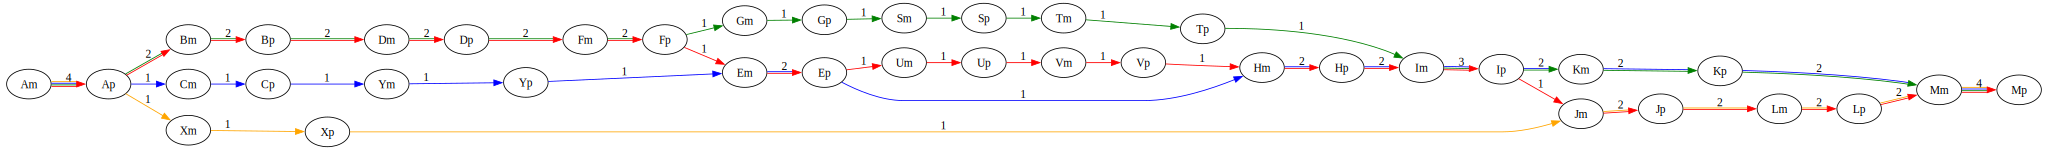

In [249]:
grafo_convertito

Calcolo ora la cover definitiva, tramite l'algoritmod i Ford-Fulkerson:

In [250]:
FORD_FULKERSON()

Cammino aumentante:
['Am', 'Ap', 'Bm', 'Bp', 'Dm', 'Dp', 'Fm', 'Fp', 'Em', 'Ep', 'Hm', 'Hp', 'Im', 'Ip', 'Km', 'Kp', 'Mm', 'Mp']
Il cammino aumentante è nella cover?
False
Cammino aumentante:
['Am']
Nessun percorso disponibile
[['Am', 'Ap', 'Bm', 'Bp', 'Dm', 'Dp', 'Fm', 'Fp', 'Gm', 'Gp', 'Sm', 'Sp', 'Tm', 'Tp', 'Im', 'Ip', 'Km', 'Kp', 'Mm', 'Mp'], ['Am', 'Ap', 'Cm', 'Cp', 'Ym', 'Yp', 'Em', 'Ep', 'Um', 'Up', 'Vm', 'Vp', 'Hm', 'Hp', 'Im', 'Ip', 'Jm', 'Jp', 'Lm', 'Lp', 'Mm', 'Mp'], ['Am', 'Ap', 'Xm', 'Xp', 'Jm', 'Jp', 'Lm', 'Lp', 'Mm', 'Mp']]


La path cover finale ottenuta è la seguente:

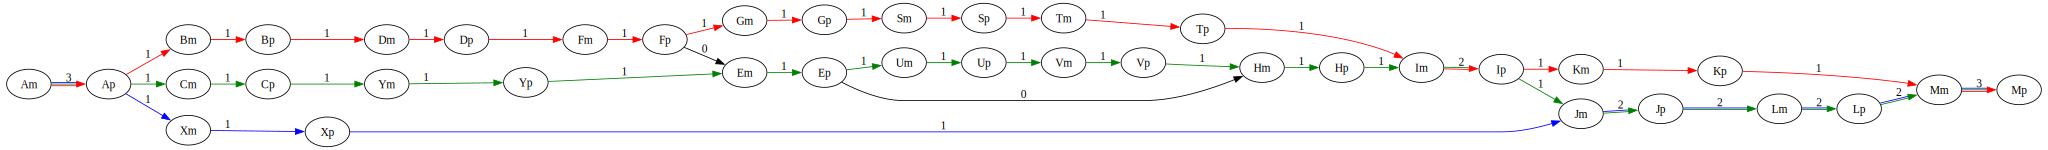

In [251]:
save_to_graphviz(G, f"{nomeGrafo} cover", PATH_FLOW, COVER, True)
grafo_cover = graphviz.Source.from_file(directory="Grafi", filename=f"{nomeGrafo} cover.dot", format="svg", engine="dot")
grafo_cover

